In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [103]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [15]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [17]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [19]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [21]:
start_date

datetime.date(2022, 4, 1)

In [23]:
start_date - pd.Timedelta(days=warmup_days)

datetime.date(2021, 6, 5)

In [25]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [27]:
end_date

datetime.date(2025, 11, 22)

In [29]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [31]:
end_date_temp = pd.Timestamp('2025-07-31').date()

In [33]:
type(end_date_temp)

datetime.date

In [35]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
df_final_prod_config_backtested_test = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_test = df_final_prod_config_backtested_test[df_final_prod_config_backtested_test.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_test = perf.calculate_asset_level_returns(df_final_prod_config_backtested_test, end_date_test, ticker_list)

portfolio_perf_metrics_prod_config_test = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_test, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_test

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.3317590416631553,
 'annualized_sharpe_ratio': 1.4134421786840479,
 'calmar_ratio': 2.560309328537423,
 'annualized_std_dev': 0.4247262948243901,
 'max_drawdown': -0.12957771858475892,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13717693836978131,
 't_statistic': 2.798163113836065,
 'p_value': 0.005237657951494762,
 'trade_count': 139.0}

In [43]:
df_final_prod_config_backtested_test.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,BTC-USD_daily_pnl,BTC-USD_daily_pct_returns,BTC-USD_position_count,ETH-USD_daily_pnl,ETH-USD_daily_pct_returns,ETH-USD_position_count,SOL-USD_daily_pnl,SOL-USD_daily_pct_returns,SOL-USD_position_count,ADA-USD_daily_pnl,

<Axes: title={'center': '5 Coin Strategy Total Portfolio Value'}, xlabel='date'>

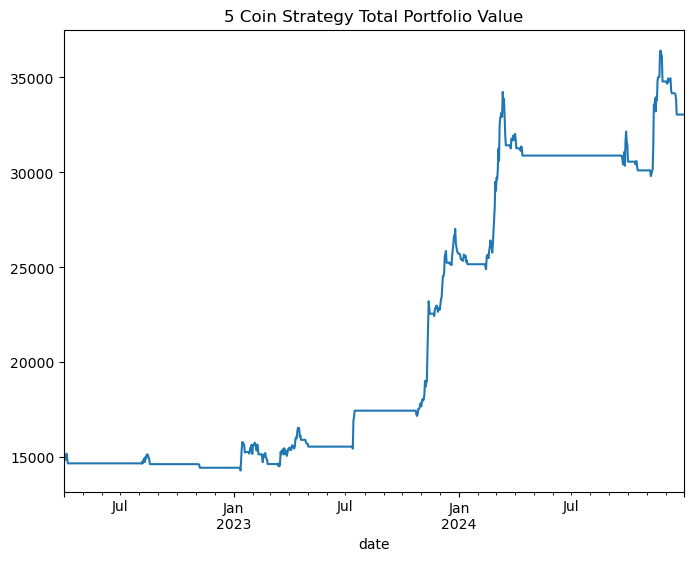

In [37]:
df_final_prod_config_backtested_test['total_portfolio_value'].plot(figsize=(8,6), title='5 Coin Strategy Total Portfolio Value')

<Axes: title={'center': '5 Coin Strategy Target Notional'}, xlabel='date'>

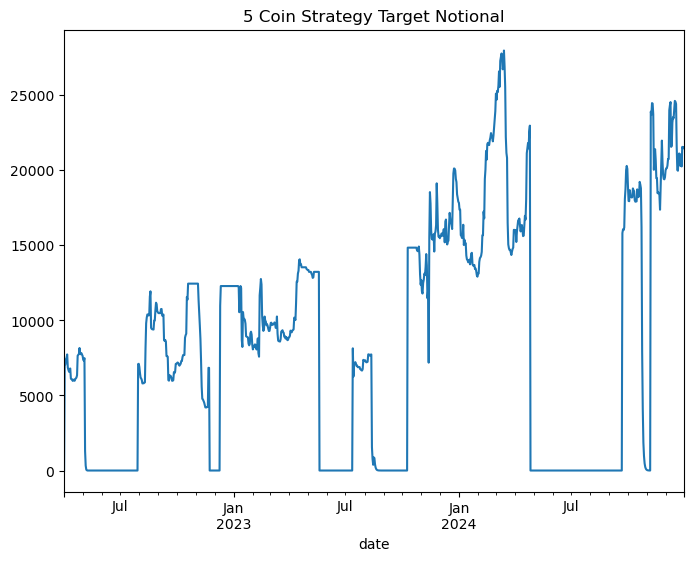

In [36]:
df_final_prod_config_backtested_test['total_target_notional'].plot(figsize=(8,6), title='5 Coin Strategy Target Notional')

<Axes: title={'center': '5 Coin Strategy Actual Position Notional'}, xlabel='date'>

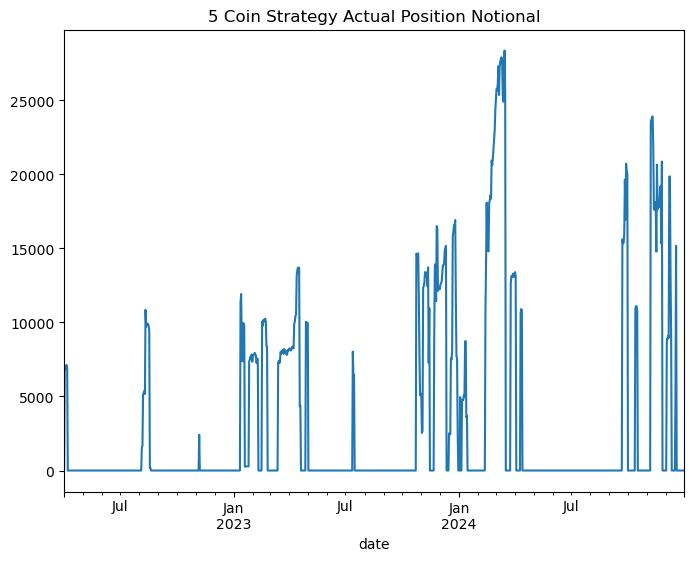

In [38]:
df_final_prod_config_backtested_test['total_actual_position_notional'].plot(figsize=(8,6), title='5 Coin Strategy Actual Position Notional')

<Axes: xlabel='date'>

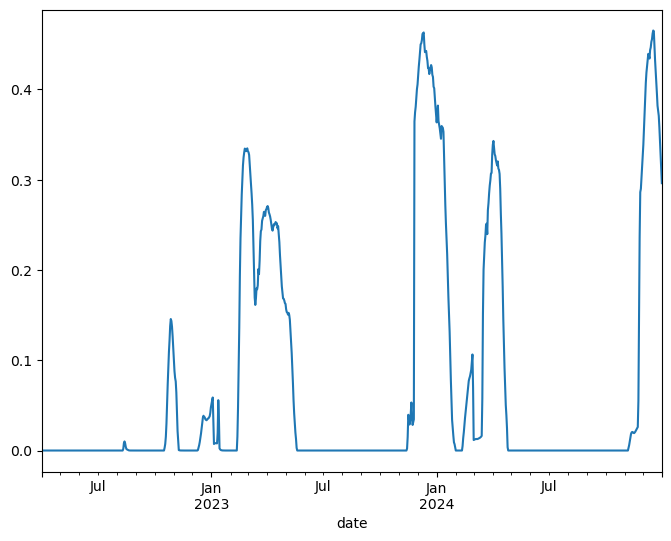

In [39]:
df_final_prod_config_backtested_test['BTC-USD_final_signal'].plot(figsize=(8,6))

In [40]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

<Axes: xlabel='date'>

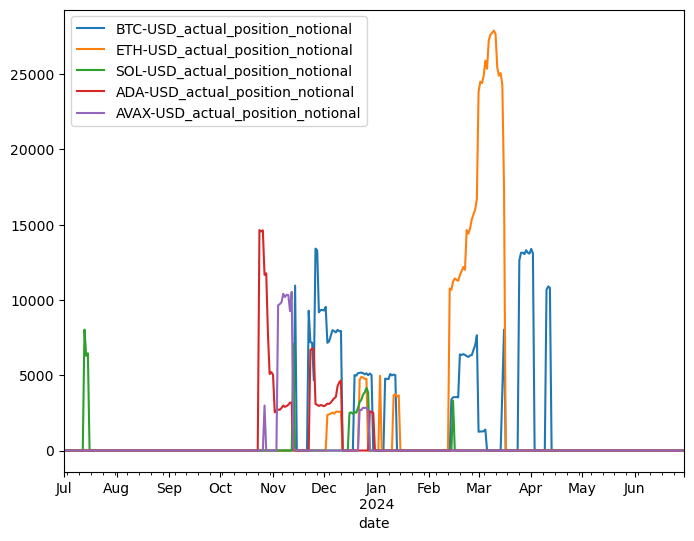

In [83]:
actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
df_final_prod_config_backtested_test[(df_final_prod_config_backtested_test.index >= pd.Timestamp('2023-07-01')) & (df_final_prod_config_backtested_test.index <= pd.Timestamp('2024-06-30'))][actual_position_notional_cols].plot(figsize=(8,6))

<Axes: xlabel='date'>

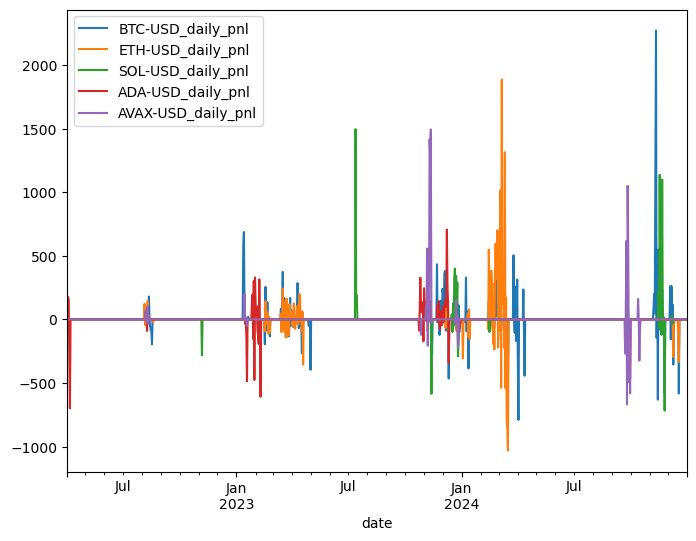

In [47]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config_backtested_test[daily_pnl_cols].plot(figsize=(8,6))

In [95]:
final_weighted_additive_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_final_prod_config_backtested_test[((df_final_prod_config_backtested_test.index >= pd.Timestamp('2023-10-01')) &
                                      (df_final_prod_config_backtested_test.index <= pd.Timestamp('2023-10-31')))][final_weighted_additive_signal_cols]

,BTC-USD_final_weighted_additive_signal,ETH-USD_final_weighted_additive_signal,SOL-USD_final_weighted_additive_signal,ADA-USD_final_weighted_additive_signal,AVAX-USD_final_weighted_additive_signal
date,,,,,
2023-10-01,-0.387492,-0.410644,-0.145097,-0.266143,-0.431290
2023-10-02,-0.369007,-0.390485,-0.094254,-0.226078,-0.412398
2023-10-03,-0.357815,-0.384545,-0.052047,-0.198262,-0.404234
2023-10-04,-0.348035,-0.379194,-0.009342,-0.167694,-0.393403
2023-10-05,-0.334373,-0.375332,0.024455,-0.140478,-0.365326
2023-10-06,-0.323921,-0.379320,0.050193,-0.109943,-0.335563
2023-10-07,-0.307568,-0.372291,0.081271,-0.068961,-0.290397
2023-10-08,-0.292081,-0.368592,0.107992,-0.037108,-0.251291
2023-10-09,-0.278553,-0.365033,0.131011,-0.010035,-0.220103


In [91]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config_backtested_test[((df_final_prod_config_backtested_test.index >= pd.Timestamp('2023-10-01')) &
                                      (df_final_prod_config_backtested_test.index <= pd.Timestamp('2023-10-31')))][final_signal_cols]

,BTC-USD_final_signal,ETH-USD_final_signal,SOL-USD_final_signal,ADA-USD_final_signal,AVAX-USD_final_signal
date,,,,,
2023-10-01,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
2023-10-02,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
2023-10-03,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
2023-10-04,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
2023-10-05,0.000000e+00,0.0,4.322411e-31,0.000000,0.000000
2023-10-06,0.000000e+00,0.0,4.435910e-31,0.000000,0.000000
2023-10-07,0.000000e+00,0.0,3.591226e-31,0.000000,0.000000
2023-10-08,0.000000e+00,0.0,2.385976e-31,0.000000,0.000000
2023-10-09,0.000000e+00,0.0,1.447284e-31,0.000000,0.000000


In [89]:
df_final_prod_config_backtested_test[((df_final_prod_config_backtested_test.index >= pd.Timestamp('2023-10-01')) &
                                      (df_final_prod_config_backtested_test.index <= pd.Timestamp('2023-12-01')))][actual_position_notional_cols]

,BTC-USD_actual_position_notional,ETH-USD_actual_position_notional,SOL-USD_actual_position_notional,ADA-USD_actual_position_notional,AVAX-USD_actual_position_notional
date,,,,,
2023-10-01,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-02,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-03,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-04,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-05,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-06,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-07,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-08,0.000000,0.0,0.00000,0.000000,0.000000
2023-10-09,0.000000,0.0,0.00000,0.000000,0.000000


In [ ]:
def get_target_volatility_daily_portfolio_positions(df, ticker_list, initial_capital, rolling_cov_window,
                                                    stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                    highest_high_window, cash_buffer_percentage,
                                                    annualized_target_volatility, transaction_cost_est=0.001,
                                                    passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                    min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                    annual_trading_days=365, use_specific_start_date=False,
                                                    signal_start_date=None):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                   total_portfolio_value_upper_limit)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [37]:
## Code to generate Trend Following Signal with Moving Avg Crossover, Donchian Channel, Rolling R Squared and Vol of Vol Signals
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
        highest_high_window=56, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
        use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
        cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
        use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    # date_list = cn.coinbase_start_date_by_ticker_dict
    # ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_alt(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## L1 Coin Performance Research

### L1 First Ticker List

In [109]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list = ['DOGE-USD','ADA-USD','DOT-USD','ALGO-USD','XLM-USD']
df_final_prod_config_backtested_alt_strategy_l1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_alt_strategy_l1 = df_final_prod_config_backtested_alt_strategy_l1[df_final_prod_config_backtested_alt_strategy_l1.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_alt_strategy_l1 = perf.calculate_asset_level_returns(df_final_prod_config_backtested_alt_strategy_l1, end_date_test, l1_ticker_list)

portfolio_perf_metrics_prod_config_alt_strategy_l1 = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_alt_strategy_l1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_alt_strategy_l1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
DOGE-USD
ADA-USD
DOT-USD
ALGO-USD
XLM-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2666699073784242,
 'annualized_sharpe_ratio': 1.1244924046398763,
 'calmar_ratio': 1.7148532356382575,
 'annualized_std_dev': 0.45476402392223886,
 'max_drawdown': -0.15550596507996287,
 'max_drawdown_duration': Timedelta('583 days 00:00:00'),
 'hit_rate': 0.09542743538767395,
 't_statistic': 2.314171948050627,
 'p_value': 0.02085919837216575,
 'trade_count': 118.0}

<Axes: xlabel='date'>

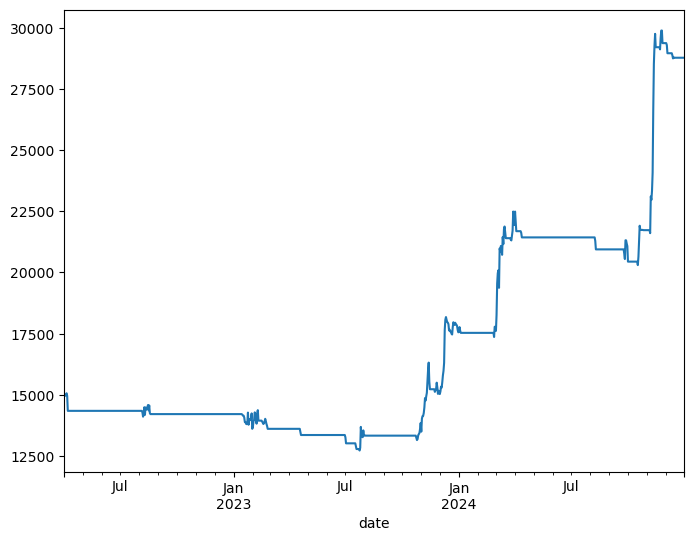

In [131]:
df_final_prod_config_backtested_alt_strategy_l1['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

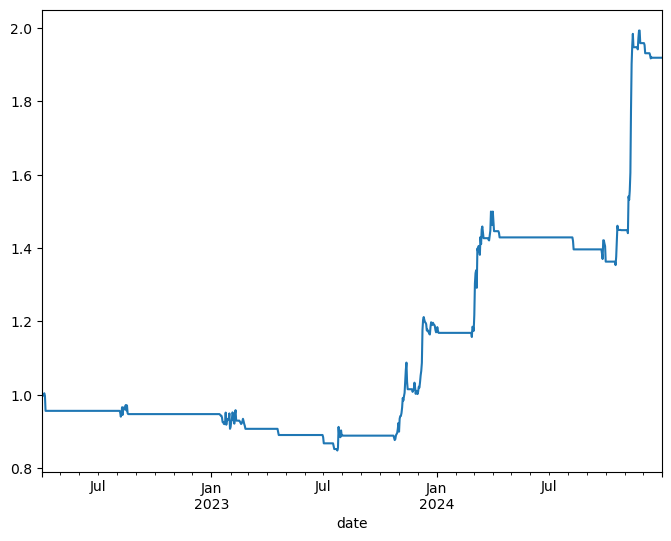

In [133]:
df_final_prod_config_backtested_alt_strategy_l1['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

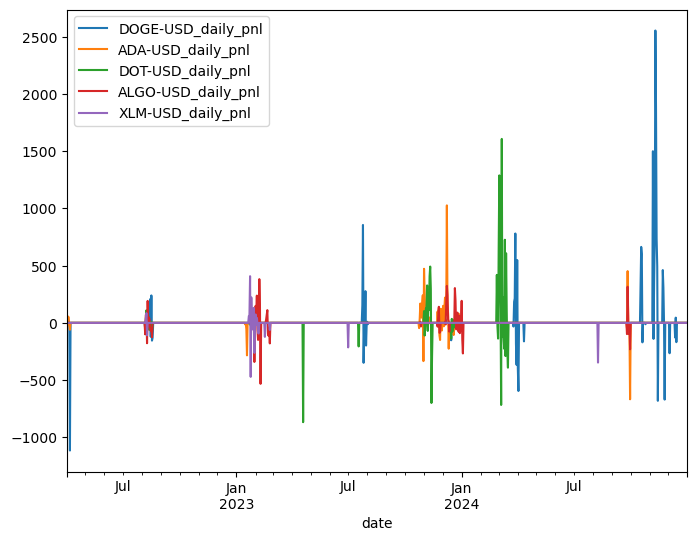

In [115]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_ticker_list]
df_final_prod_config_backtested_alt_strategy_l1[daily_pnl_cols].plot(figsize=(8,6))

<Axes: xlabel='date'>

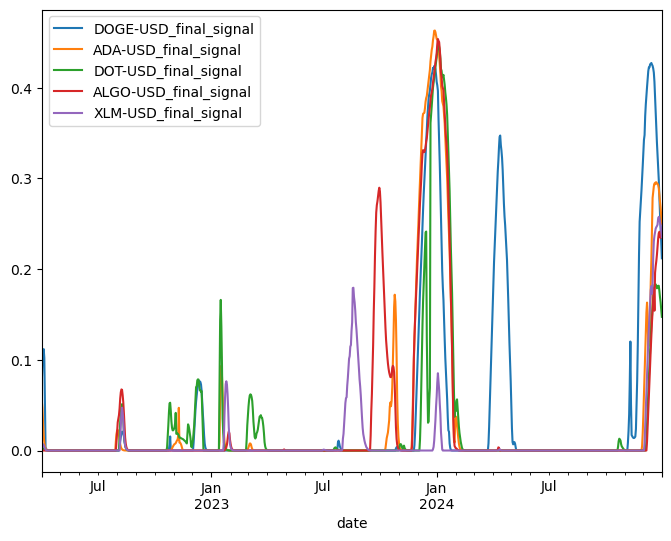

In [121]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_ticker_list]
df_final_prod_config_backtested_alt_strategy_l1[final_signal_cols].plot(figsize=(8,6))

### L1 Second Ticker List

In [119]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list_2 = ['ATOM-USD','ICP-USD','XTZ-USD','FIL-USD','CRO-USD']
df_final_prod_config_backtested_alt_strategy_l1_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list_2, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_alt_strategy_l1_2 = df_final_prod_config_backtested_alt_strategy_l1_2[df_final_prod_config_backtested_alt_strategy_l1_2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_alt_strategy_l1_2 = perf.calculate_asset_level_returns(df_final_prod_config_backtested_alt_strategy_l1_2, end_date_test, l1_ticker_list_2)

portfolio_perf_metrics_prod_config_alt_strategy_l1_2 = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_alt_strategy_l1_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                              strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_alt_strategy_l1_2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ATOM-USD
ICP-USD
XTZ-USD
FIL-USD
CRO-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.3185216253968377,
 'annualized_sharpe_ratio': 1.1081978101380405,
 'calmar_ratio': 2.9471902298463775,
 'annualized_std_dev': 0.6905356769257829,
 'max_drawdown': -0.10807637124035956,
 'max_drawdown_duration': Timedelta('248 days 00:00:00'),
 'hit_rate': 0.08151093439363817,
 't_statistic': 2.1968879401670405,
 'p_value': 0.02825614230523823,
 'trade_count': 111.0}

In [78]:
df_final_prod_config_backtested_alt_strategy_l1_2.head()

,ATOM-USD_20_avg_true_range_price,ATOM-USD_actual_position_notional,ATOM-USD_actual_position_size,ATOM-USD_annualized_volatility_30,ATOM-USD_close,ATOM-USD_cooldown_counter,ATOM-USD_event,ATOM-USD_final_signal,ATOM-USD_final_weighted_additive_signal,ATOM-USD_highest_high_56,ATOM-USD_lowest_low_56,ATOM-USD_new_position_entry_exit_price,ATOM-USD_new_position_notional,ATOM-USD_new_position_size,ATOM-USD_open,ATOM-USD_open_position_notional,ATOM-USD_open_position_size,ATOM-USD_short_sale_proceeds,ATOM-USD_stop_loss,ATOM-USD_stopout_flag,ATOM-USD_t_1_close,ATOM-USD_t_1_close_pct_returns,ATOM-USD_target_notional,ATOM-USD_target_size,ATOM-USD_target_vol_normalized_weight,ATOM-USD_vol_adjusted_trend_signal,ICP-USD_20_avg_true_range_price,ICP-USD_actual_position_notional,ICP-USD_actual_position_size,ICP-USD_annualized_volatility_30,ICP-USD_close,ICP-USD_cooldown_counter,ICP-USD_event,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_highest_high_56,ICP-USD_lowest_low_56,ICP-USD_new_position_entry_exit_price,ICP-USD_new_position_notional,ICP-USD_new_position_size,ICP-USD_open,ICP-USD_open_position_notional,ICP-USD_open_position_size,ICP-USD_short_sale_proceeds,ICP-USD_stop_loss,ICP-USD_stopout_flag,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_target_notional,ICP-USD_target_size,ICP-USD_target_vol_normalized_weight,ICP-USD_vol_adjusted_trend_signal,XTZ-USD_20_avg_true_range_price,XTZ-USD_actual_position_notional,XTZ-USD_actual_position_size,XTZ-USD_annualized_volatility_30,XTZ-USD_close,XTZ-USD_cooldown_counter,XTZ-USD_event,XTZ-USD_final_signal,XTZ-USD_final_weighted_additive_signal,XTZ-USD_highest_high_56,XTZ-USD_lowest_low_56,XTZ-USD_new_position_entry_exit_price,XTZ-USD_new_position_notional,XTZ-USD_new_position_size,XTZ-USD_open,XTZ-USD_open_position_notional,XTZ-USD_open_position_size,XTZ-USD_short_sale_proceeds,XTZ-USD_stop_loss,XTZ-USD_stopout_flag,XTZ-USD_t_1_close,XTZ-USD_t_1_close_pct_returns,XTZ-USD_target_notional,XTZ-USD_target_size,XTZ-USD_target_vol_normalized_weight,XTZ-USD_vol_adjusted_trend_signal,FIL-USD_20_avg_true_range_price,FIL-USD_actual_position_notional,FIL-USD_actual_position_size,FIL-USD_annualized_volatility_30,FIL-USD_close,FIL-USD_cooldown_counter,FIL-USD_event,FIL-USD_final_signal,FIL-USD_final_weighted_additive_signal,FIL-USD_highest_high_56,FIL-USD_lowest_low_56,FIL-USD_new_position_entry_exit_price,FIL-USD_new_position_notional,FIL-USD_new_position_size,FIL-USD_open,FIL-USD_open_position_notional,FIL-USD_open_position_size,FIL-USD_short_sale_proceeds,FIL-USD_stop_loss,FIL-USD_stopout_flag,FIL-USD_t_1_close,FIL-USD_t_1_close_pct_returns,FIL-USD_target_notional,FIL-USD_target_size,FIL-USD_target_vol_normalized_weight,FIL-USD_vol_adjusted_trend_signal,CRO-USD_20_avg_true_range_price,CRO-USD_actual_position_notional,CRO-USD_actual_position_size,CRO-USD_annualized_volatility_30,CRO-USD_close,CRO-USD_cooldown_counter,CRO-USD_event,CRO-USD_final_signal,CRO-USD_final_weighted_additive_signal,CRO-USD_highest_high_56,CRO-USD_lowest_low_56,CRO-USD_new_position_entry_exit_price,CRO-USD_new_position_notional,CRO-USD_new_position_size,CRO-USD_open,CRO-USD_open_position_notional,CRO-USD_open_position_size,CRO-USD_short_sale_proceeds,CRO-USD_stop_loss,CRO-USD_stopout_flag,CRO-USD_t_1_close,CRO-USD_t_1_close_pct_returns,CRO-USD_target_notional,CRO-USD_target_size,CRO-USD_target_vol_normalized_weight,CRO-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,ATOM-USD_daily_pnl,ATOM-USD_daily_pct_returns,ATOM-USD_position_count,ICP-USD_daily_pnl,ICP-USD_daily_pct_returns,ICP-USD_position_count,XTZ-USD_daily_pnl,XTZ-USD_daily_pct_returns,XTZ-USD_position_count,FIL-USD_daily_p

<Axes: xlabel='date'>

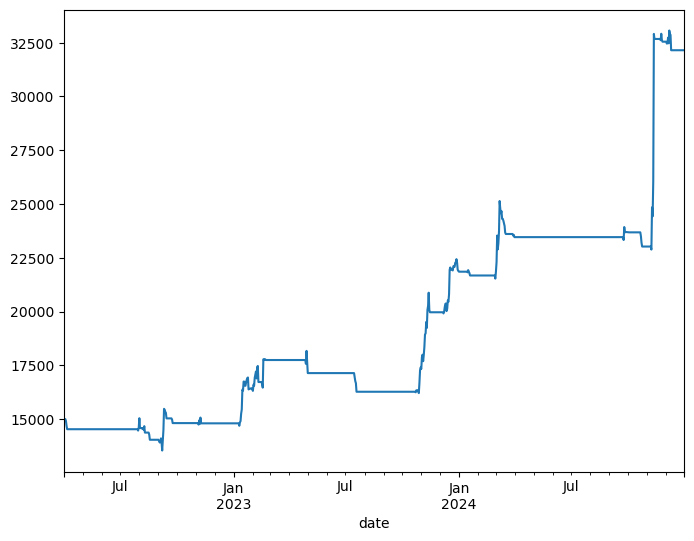

In [125]:
df_final_prod_config_backtested_alt_strategy_l1_2['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

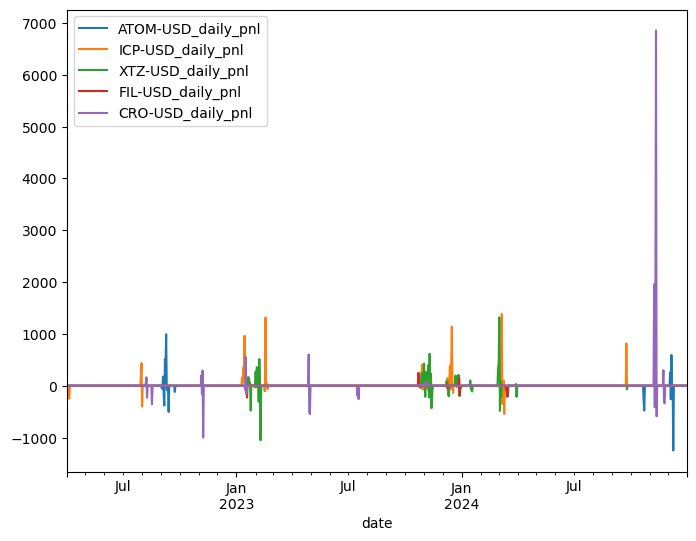

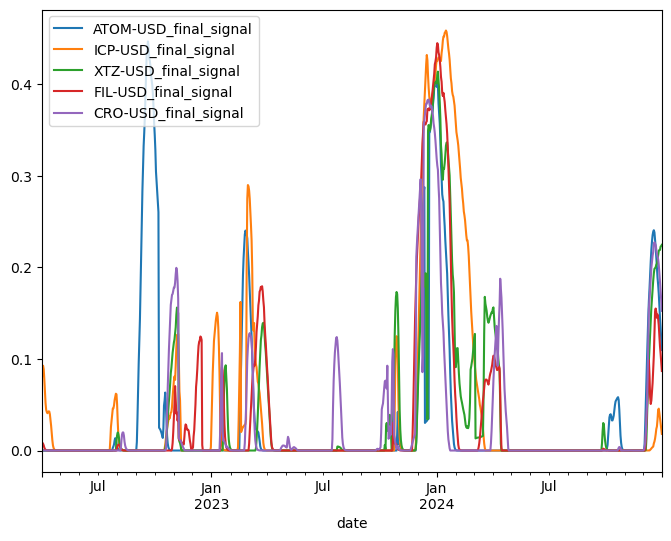

In [129]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_ticker_list_2]
df_final_prod_config_backtested_alt_strategy_l1_2[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_ticker_list_2]
df_final_prod_config_backtested_alt_strategy_l1_2[final_signal_cols].plot(figsize=(8,6))

### L1 Larger Universe Ticker Test

In [94]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l1_ticker_list_expanded = ['ATOM-USD','ICP-USD','XTZ-USD','FIL-USD','CRO-USD','DOGE-USD','ADA-USD','DOT-USD','ALGO-USD','XLM-USD']
df_final_prod_config_backtested_alt_strategy_l1_expand = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l1_ticker_list_expanded, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_alt_strategy_l1_expand = df_final_prod_config_backtested_alt_strategy_l1_expand[df_final_prod_config_backtested_alt_strategy_l1_expand.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_alt_strategy_l1_expand = perf.calculate_asset_level_returns(df_final_prod_config_backtested_alt_strategy_l1_expand, end_date_test, l1_ticker_list_expanded)

portfolio_perf_metrics_prod_config_alt_strategy_l1_expand = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_alt_strategy_l1_expand, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                              strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_alt_strategy_l1_expand

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ATOM-USD
ICP-USD
XTZ-USD
FIL-USD
CRO-USD
DOGE-USD
ADA-USD
DOT-USD
ALGO-USD
XLM-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.20230513271834605,
 'annualized_sharpe_ratio': 0.8903605677277916,
 'calmar_ratio': 1.4889264699613725,
 'annualized_std_dev': 0.4550770875399699,
 'max_drawdown': -0.13587315209971013,
 'max_drawdown_duration': Timedelta('248 days 00:00:00'),
 'hit_rate': 0.0874751491053678,
 't_statistic': 1.9616891353171184,
 'p_value': 0.05007440371360357,
 'trade_count': 113.0}

<Axes: xlabel='date'>

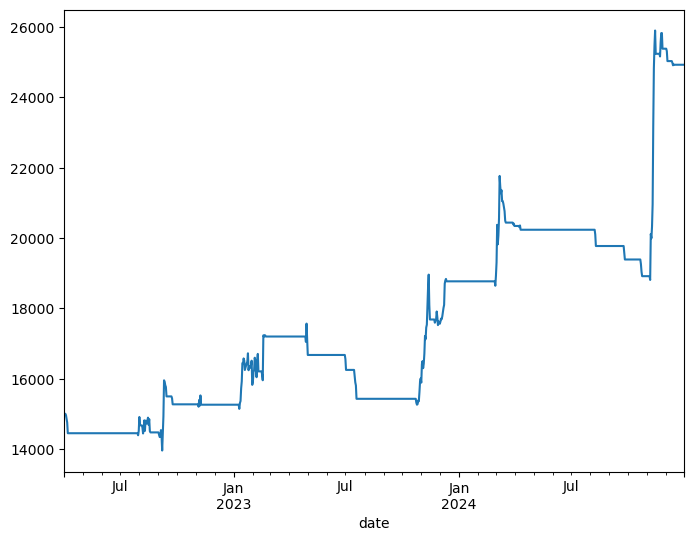

In [135]:
df_final_prod_config_backtested_alt_strategy_l1_expand['total_portfolio_value'].plot(figsize=(8,6))

<Axes: xlabel='date'>

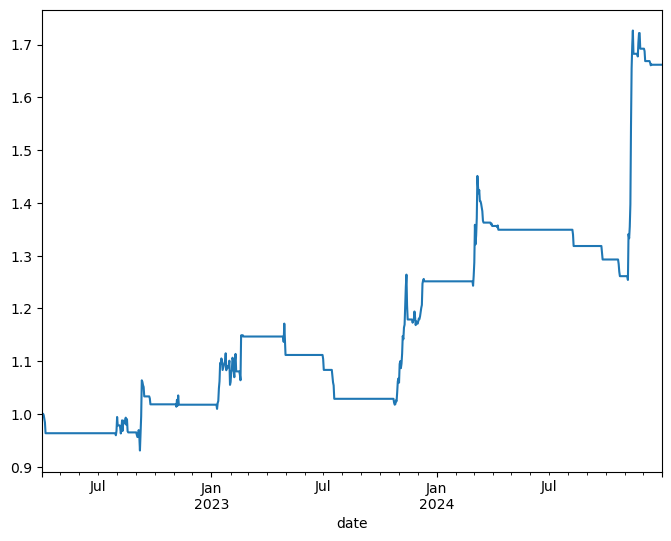

In [137]:
df_final_prod_config_backtested_alt_strategy_l1_expand['equity_curve'].plot(figsize=(8,6))

<Axes: xlabel='date'>

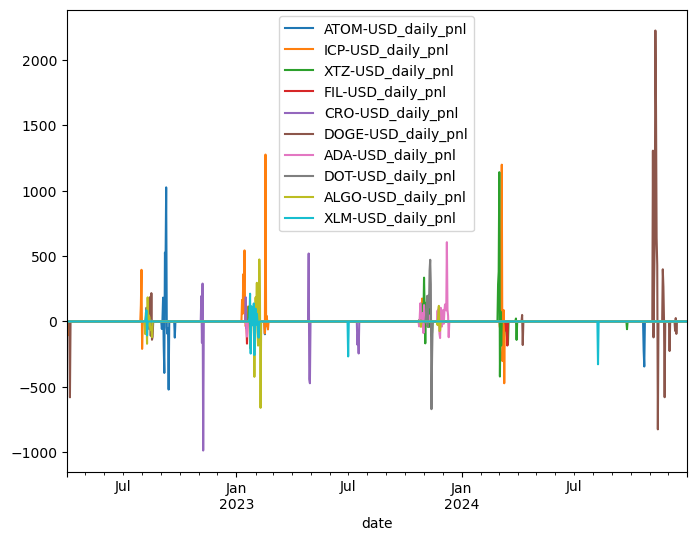

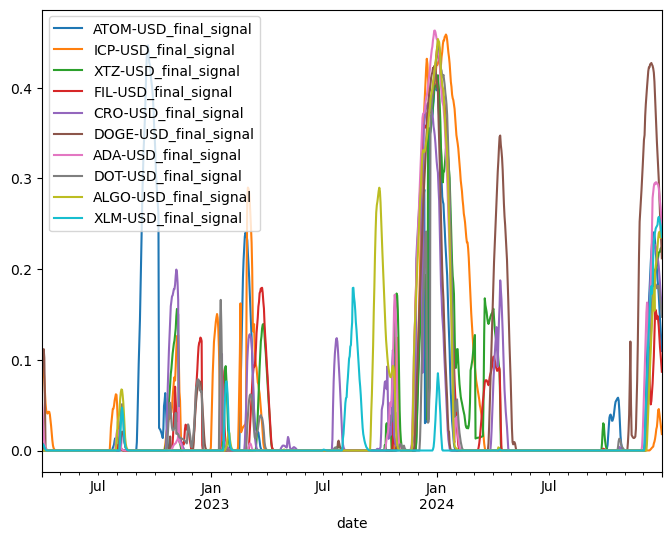

In [139]:
daily_pnl_cols = [f'{ticker}_daily_pnl' for ticker in l1_ticker_list_expanded]
df_final_prod_config_backtested_alt_strategy_l1_expand[daily_pnl_cols].plot(figsize=(8,6))

final_signal_cols = [f'{ticker}_final_signal' for ticker in l1_ticker_list_expanded]
df_final_prod_config_backtested_alt_strategy_l1_expand[final_signal_cols].plot(figsize=(8,6))

## L2 Coins Performance Research

In [105]:
missing_l2_ticker_list = ['ZK-USD','MNT-USD','MANTA-USD','LRC-USD','ZORA-USD','POL-USD','METIS-USD','STX-USD']
missing_l2_ticker_start_date_dict = cn.determine_coinbase_start_date(ticker_list=missing_l2_ticker_list)

Checking data for ZK-USD: 2016-01-01 00:00:00


2025-11-22 12:23:59 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


Data available from: 2024-09-25
First available date for ZK-USD: 2024-09-25
Checking data for MNT-USD: 2016-01-01 00:00:00
HTTPError encountered for MNT-USD. Skipping further checks.
No data available within the date range for MNT-USD.
Checking data for MANTA-USD: 2016-01-01 00:00:00


2025-11-22 12:23:59 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"ProductID is invalid","message":"ProductID is invalid"}


HTTPError encountered for MANTA-USD. Skipping further checks.
No data available within the date range for MANTA-USD.
Checking data for LRC-USD: 2016-01-01 00:00:00
Data available from: 2020-09-15
First available date for LRC-USD: 2020-09-15
Checking data for ZORA-USD: 2016-01-01 00:00:00
Data available from: 2025-04-24
First available date for ZORA-USD: 2025-04-24
Checking data for POL-USD: 2016-01-01 00:00:00
Data available from: 2024-09-04
First available date for POL-USD: 2024-09-04
Checking data for METIS-USD: 2016-01-01 00:00:00
Data available from: 2022-06-28
First available date for METIS-USD: 2022-06-28
Checking data for STX-USD: 2016-01-01 00:00:00
Data available from: 2022-01-20
First available date for STX-USD: 2022-01-20


In [107]:
missing_l2_ticker_start_date_dict

{'ZK-USD': '2024-09-25',
 'MNT-USD': None,
 'MANTA-USD': None,
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'POL-USD': '2024-09-04',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'}

In [155]:
start_date_test = pd.Timestamp('2022-04-01').date()
end_date_test = pd.Timestamp('2024-12-31').date()
l2_ticker_list = ['SKL-USD','LRC-USD','IMX-USD']
df_final_prod_config_backtested_alt_strategy_l2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_alt(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=l2_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_alt_strategy_l2 = df_final_prod_config_backtested_alt_strategy_l2[df_final_prod_config_backtested_alt_strategy_l2.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_alt_strategy_l2 = perf.calculate_asset_level_returns(df_final_prod_config_backtested_alt_strategy_l2, end_date_test, l2_ticker_list)

portfolio_perf_metrics_prod_config_alt_strategy_l2 = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_alt_strategy_l2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_alt_strategy_l2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SKL-USD
LRC-USD
IMX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


KeyError: 'LRC-USD'

In [ ]:
df_final_prod_config_backtested_alt_strategy_2['total_portfolio_value'].plot()

In [ ]:
df_final_prod_config_backtested = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date_temp, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config_backtested = df_final_prod_config_backtested[df_final_prod_config_backtested.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested = perf.calculate_asset_level_returns(df_final_prod_config_backtested, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config_backtested, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

In [ ]:
end_date

In [ ]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

In [ ]:
df_final_prod_config.tail(5)

In [ ]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][final_signal_cols].plot(figsize=(10,8))

In [ ]:
raw_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][raw_signal_cols].plot(figsize=(10,8))

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ['BTC-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ['ETH-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ['SOL-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ['ADA-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ['AVAX-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))